In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

# Introducing contact resistance between 2 tapes

- In this model we consider two tapes 1 m long divided in three sections.
- Electric field criterion for ngspice model is 100 microV/m

In [2]:
def readdata(filename):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)


        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [3]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 10E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# Tapes divided in three sections: comparing short and open contact

<img src="3 sections.png">

### Here we change the termination resistance with Rt
If we would like to simulate 25 uOhm then you we to set twice this value, 50 uOhm

In [4]:
# Definitions

# Function to generate netlist for ngspice
def generatenetlist(filename,Rc):
    Imax = 250
    Ic1 = 100
    Ic2 = 50
    Rt = 50E-6 # Here we change the joint resistance. 
    n = 30
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n') # Name of the circuit as a comment
        output.write('I1 0 N001 100\n') # Current source
        output.write(f'rt1 N002 N001 {Rt/2}\n')
        output.write(f'rt2 0 N005 {Rt/2}\n')
        output.write(f'rt3 N006 N001 {Rt/2}\n')
        output.write(f'rt4 N009 0 {Rt/2}\n')
        output.write(f'r1 N006 N002 {Rc}\n')
        output.write(f'r2 N007 N003 {Rc}\n')
        output.write(f'r3 N008 N004 {Rc}\n')
        output.write(f'r4 N009 N005 {Rc}\n')
        output.write(f'b1 N002 N003 V=33E-6*pow((I(b1)/{Ic1}),{n})\n')
        output.write(f'b2 N003 N004 V=33E-6*pow((I(b2)/{Ic1}),{n})\n')
        output.write(f'b3 N004 N005 V=33E-6*pow((I(b3)/{Ic1}),{n})\n')
        output.write(f'b4 N006 N007 V=33E-6*pow((I(b4)/{Ic2}),{n})\n')
        output.write(f'b5 N007 N008 V=33E-6*pow((I(b5)/{Ic2}),{n})\n')
        output.write(f'b6 N008 N009 V=33E-6*pow((I(b6)/{Ic2}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        #output.write('.print dc  V(n001) I(B1)\n')
        #output.write('.print dc V(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.print dc v(n001) v(n002) v(n003) v(n004) v(n005) v(n006) v(n007) v(n008) v(n009) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.end\n')

Fitting results


<IPython.core.display.Javascript object>


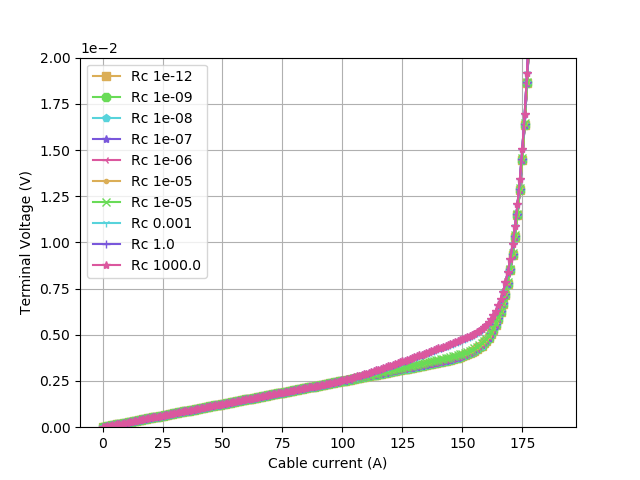

Rc 1e-12: Rt = 2.49984e-05, Ic = 138.9639, n = 29.9997, Fit-error = 4.8889e-06

Rc 1e-09: Rt = 2.49984e-05, Ic = 138.9639, n = 29.9997, Fit-error = 4.8926e-06

Rc 1e-08: Rt = 2.4999e-05, Ic = 138.964, n = 29.9997, Fit-error = 4.9355e-06

Rc 1e-07: Rt = 2.50048e-05, Ic = 138.9642, n = 29.9999, Fit-error = 6.5832e-06

Rc 1e-06: Rt = 2.50639e-05, Ic = 138.9669, n = 30.0018, Fit-error = 4.53931e-05

Rc 1e-05: Rt = 2.55672e-05, Ic = 138.9803, n = 30.0107, Fit-error = 0.0004312655

Rc 1e-05: Rt = 2.55672e-05, Ic = 138.9803, n = 30.0107, Fit-error = 0.0004312655

Rc 0.001: Rt = 2.82069e-05, Ic = 138.898, n = 29.9458, Fit-error = 0.0027057832

Rc 1.0: Rt = 2.83767e-05, Ic = 138.8986, n = 29.9456, Fit-error = 0.0028602849

Rc 1000.0: Rt = 2.83769e-05, Ic = 138.8986, n = 29.9456, Fit-error = 0.002860451



In [9]:
%matplotlib notebook

# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep']
num_resistances = 4
num_vsources = 6
num_nodes = 9
for i in range(num_nodes):
    Labels.append(f'v(n00{i+1})')
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')

    
#print(Labels)

print('Fitting results')

# Testing different values of contact resistance
Rc = np.array([1E-12,1E-9,10E-9,1E-7,1E-6,1E-5,1E-5,1E-3,1,1000])
markers = ["s","8","p","*","3",".","x","1","+",'*']
sns.set_palette(sns.color_palette("hls", len(Rc)))
# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'Rc {Rc[i]}.cir'
    generatenetlist(filename,Rc[i])
    data = readdata(filename)
   
    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rc {Rc[i]}')
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100000e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    plt.plot(Icable_lim,Vt_lim)
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rc {Rc[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,label = f'Rc {Rc[i]}',marker = markers[i])
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[i]} 3S')



    
plt.ylim(0,0.2E-1)
#plt.xlim(0,150)
plt.xlabel('Cable current (A)')
plt.ylabel('Terminal Voltage (V)')
#plt.title('Terminal voltage')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.savefig('Plots/2-rc-sweepRt25micro.png',dpi=500)
plt.show()